<a href="https://www.kaggle.com/code/hilalalpak/breast-cancer-diagnosis-prediction-via-ann?scriptVersionId=196991147" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link href="https://fonts.googleapis.com/css2?family=Fredoka+One&display=swap" rel="stylesheet">
</head>
<body>
    <div style="border-radius: 0 20px 0 0; border: 3px solid #2F4F4F; background-color:#EC8C8C; padding:2px; margin-bottom: 10px;">
            <p style="margin: 0; font-size: 30px; text-align: center; font-family: Roboto; font-weight: bold; letter-spacing: 2px; color:#F8F8F0">Breast Cancer Diagnosis Prediction</p> 
    </div>
</body>
</html>

<div style="text-align: center;">
    <img src="https://www.verywellhealth.com/thmb/-ygDZAscHm6EIYzKp-WusRBDgYk=/750x0/filters:no_upscale():max_bytes(150000):strip_icc()/breast-fat-necrosis-430691-v1-eff5292762cf48d29df217d2e014e9df.png" width="700" alt="Meme Cancer Infographic">
</div>

<div style="text-align:center; font-size:25px; border: 3px solid #2F4F4F; border-radius: 5px; padding: 8px; margin-bottom: 10px; background-color:#F8F8F0 ; font-family: Roboto ; font-weight: bold; color: #2F4F4F;">Data Preparation
</div>

In [1]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [2]:
import numpy as np
import pandas as pd
from joblib import dump, load 
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

random.seed(47)
np.random.seed(47)
tf.random.set_seed(47)

In [3]:
############
# Read Data
############

data_path = '/kaggle/input/breast-cancer-wisconsin-data/data.csv'
data = pd.read_csv(data_path)

In [4]:
print(data.columns)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
##########
# Preparation
##########

# Drop unnecessary variables
data = data.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# 'diagnosis'
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

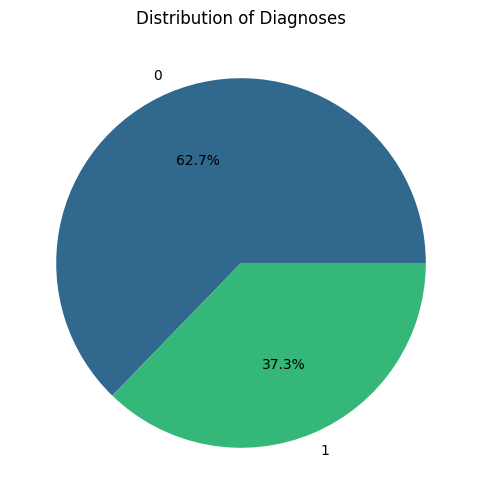

In [7]:
import seaborn as sns
diagnosis_counts = data['diagnosis'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(diagnosis_counts)))
plt.title('Distribution of Diagnoses')
plt.show();

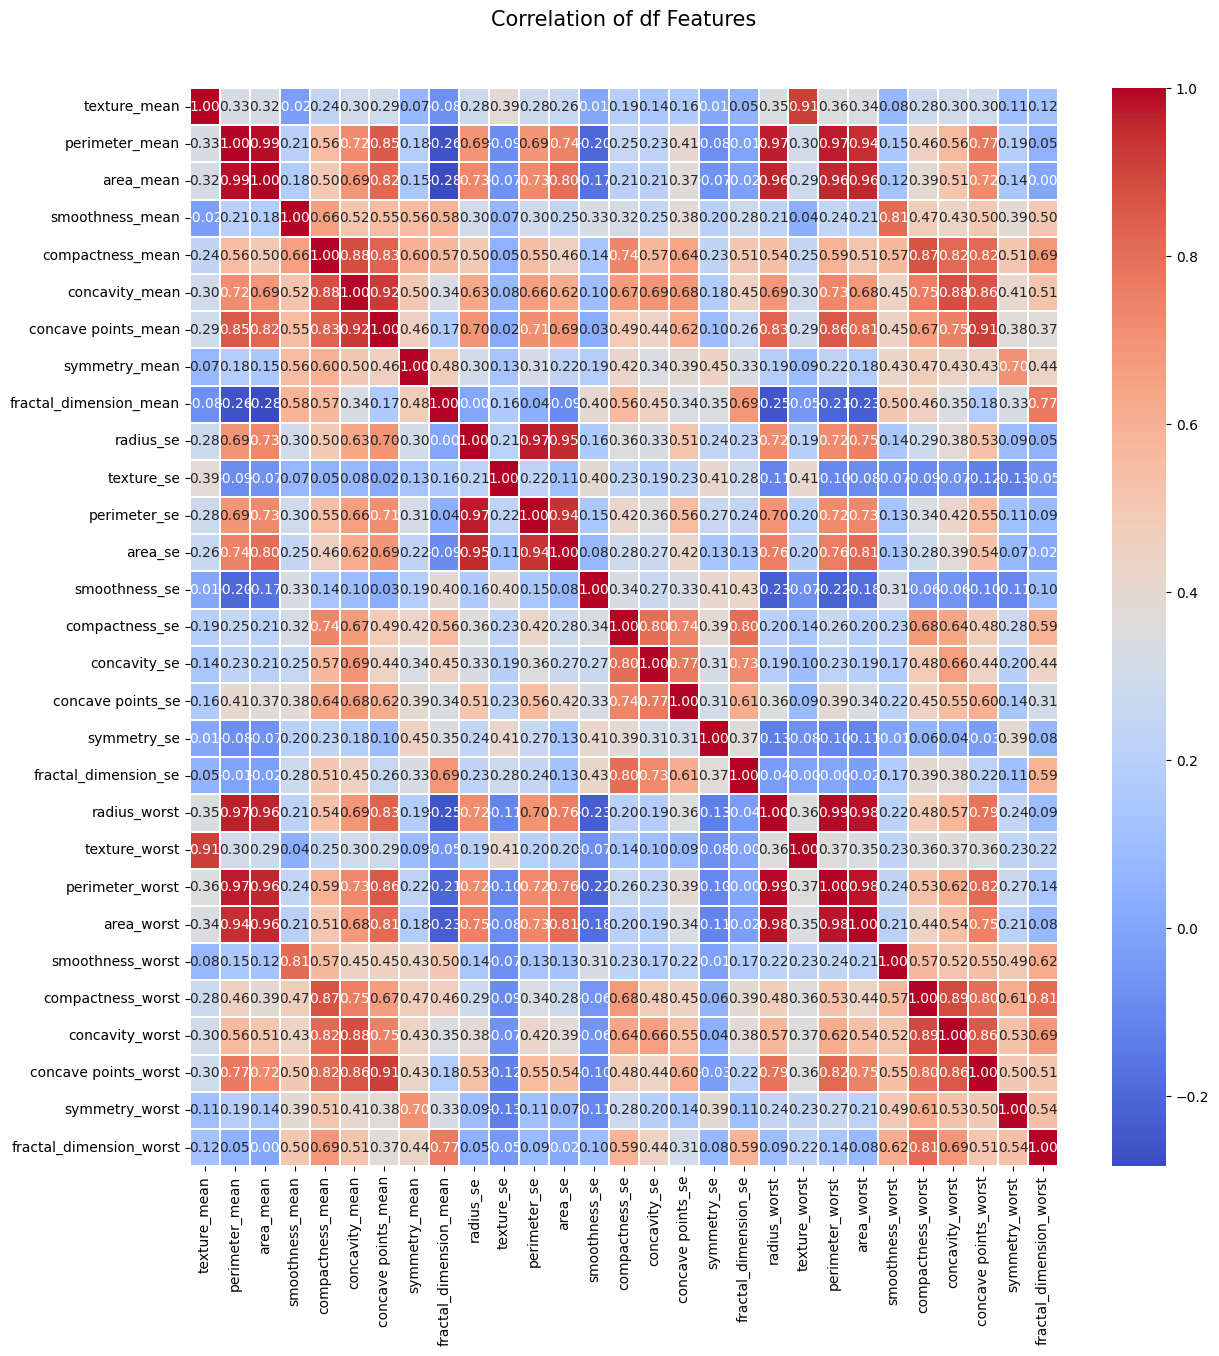

In [8]:
corr = data.iloc[:, 2:].corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.1, linecolor='white')

plt.title('Correlation of df Features', y=1.05, size=15)

plt.show();

In [9]:
## Positive High Correlation
def get_high_correlations(corr, threshold_min=0.9, threshold_max=1.0):
    high_corr_pairs = []
    columns = corr.columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            if threshold_min < corr.iloc[i, j] < threshold_max:
                high_corr_pairs.append((columns[i], columns[j], corr.iloc[i, j]))
    return high_corr_pairs


high_corr_pairs = get_high_correlations(corr, threshold_min=0.9, threshold_max=1.0)

for pair in high_corr_pairs:
    print(f"({pair[0]}, {pair[1]}) - Correlation: {pair[2]}")

(texture_mean, texture_worst) - Correlation: 0.912044588840421
(perimeter_mean, area_mean) - Correlation: 0.9865068039913907
(perimeter_mean, radius_worst) - Correlation: 0.9694763634663146
(perimeter_mean, perimeter_worst) - Correlation: 0.9703868870426394
(perimeter_mean, area_worst) - Correlation: 0.9415498080023068
(area_mean, radius_worst) - Correlation: 0.9627460860470841
(area_mean, perimeter_worst) - Correlation: 0.9591195743552645
(area_mean, area_worst) - Correlation: 0.9592133256498998
(concavity_mean, concave points_mean) - Correlation: 0.9213910263788588
(concave points_mean, concave points_worst) - Correlation: 0.9101553142985918
(radius_se, perimeter_se) - Correlation: 0.9727936770160764
(radius_se, area_se) - Correlation: 0.951830112110991
(perimeter_se, area_se) - Correlation: 0.9376554069544157
(radius_worst, perimeter_worst) - Correlation: 0.993707916102949
(radius_worst, area_worst) - Correlation: 0.9840145644590742
(perimeter_worst, area_worst) - Correlation: 0.977

<div style="background-color:#2F4F4F; border-radius: 10px; padding: 10px; margin-bottom: 20px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">Multicollinearity, or multiple linear relationships, can complicate the learning process of a model and affect prediction accuracy by repeating the same information through correlated variables. Redundant variables can increase the risk of overfitting, which deteriorates overall performance and raises model complexity and computational costs. For these reasons, I will drop one of the highly correlated variables.</p>
</div>

In [10]:
def remove_highly_correlated_features(data, threshold=0.95):
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = set()
    for column in upper.columns:
        if column not in to_drop:
            correlated_features = upper.index[upper[column] > threshold].tolist()
            if correlated_features:
                correlated_features = [feat for feat in correlated_features if feat not in to_drop]
                if correlated_features:
                    to_drop.add(correlated_features[0])
                    print(f"{column} - {correlated_features[0]}: {corr_matrix.loc[column, correlated_features[0]]:.4f}")
    
    to_drop = list(to_drop)
    print(f"\nFeatures to be removed (correlation > {threshold}):")
    print(to_drop)
    
    return data.drop(to_drop, axis=1)

In [11]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X = remove_highly_correlated_features(X, threshold=0.95)

#####################################################################

scaler = StandardScaler()
X = scaler.fit_transform(X)

print("X_scaled shape:", X.shape)
print("y shape:", y.shape)

perimeter_mean - radius_mean: 0.9979
area_mean - perimeter_mean: 0.9865
perimeter_se - radius_se: 0.9728
radius_worst - area_mean: 0.9627
perimeter_worst - radius_worst: 0.9937
area_worst - perimeter_worst: 0.9776

Features to be removed (correlation > 0.95):
['radius_mean', 'perimeter_mean', 'radius_se', 'area_mean', 'radius_worst', 'perimeter_worst']
X_scaled shape: (569, 24)
y shape: (569,)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Converting NumPy Arrays to TensorFlow Datasets

def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):

    if batch_size is None:
        batch_size = len(X_train)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size) 
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset


train_data, val_data = prepare_datasets(X_train, X_val, y_train, y_val, batch_size=16)

In [14]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 24), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<div style="text-align:center; font-size:25px; border: 3px solid #2F4F4F; border-radius: 5px; padding: 8px; margin-bottom: 10px; background-color:#F8F8F0 ; font-family: Roboto ; font-weight: bold; color: #2F4F4F;">Modeling
</div>

In [15]:
model = Sequential([
    Input(shape=(train_data.element_spec[0].shape[1],)),

    Dense(50, activation='relu', kernel_regularizer=l2(0.001)), 

    BatchNormalization(),

    Dropout(0.6),

    Dense(1, activation='sigmoid') ## binary classification
])


#### The Dropout and BatchNormalization layers are used to enhance the model's generalization ability and stabilize the training process.

<div style="background-color:#2F4F4F; border-radius: 10px; padding: 10px; margin-bottom: 20px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">The model employs various techniques to prevent overfitting, including L2 regularization, Dropout, Batch Normalization, and EarlyStopping. The use of the SGD optimizer allows the model to learn more slowly but potentially in a more stable manner.</p>
</div>

In [16]:
model.compile(optimizer= 'SGD',
              loss="binary_crossentropy",
              metrics=["accuracy", "AUC"])

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    verbose=1,
    restore_best_weights=True) 



model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

In [18]:
history = model.fit(train_data,
            epochs=100,
            validation_data=val_data,
            verbose=1,
            callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7038 - accuracy: 0.6231 - loss: 0.7394
Epoch 1: val_loss improved from inf to 0.41911, saving model to /kaggle/working/best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.7129 - accuracy: 0.6298 - loss: 0.7295 - val_AUC: 0.9753 - val_accuracy: 0.8947 - val_loss: 0.4191
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8533 - accuracy: 0.7706 - loss: 0.5559
Epoch 2: val_loss improved from 0.41911 to 0.33531, saving model to /kaggle/working/best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8545 - accuracy: 0.7719 - loss: 0.5535 - val_AUC: 0.9908 - val_accuracy: 0.9474 - val_loss: 0.3353
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9553 - accuracy: 0.8664 - loss: 0.3419
Epoch 3: val_loss improved from 0.33531 to 0.28218, saving model to /kaggle/working/best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9550 - accuracy: 0.8658 - loss: 0.3425 - val_AUC: 0.9938 - va

In [19]:
def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1
    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    return epoch_details


best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")

Best epoch details: {'AUC': 0.9889311790466309, 'accuracy': 0.9692307710647583, 'loss': 0.12933558225631714, 'val_AUC': 0.9978710412979126, 'val_accuracy': 0.9736841917037964, 'val_loss': 0.09469354152679443, 'best_epoch': 91}


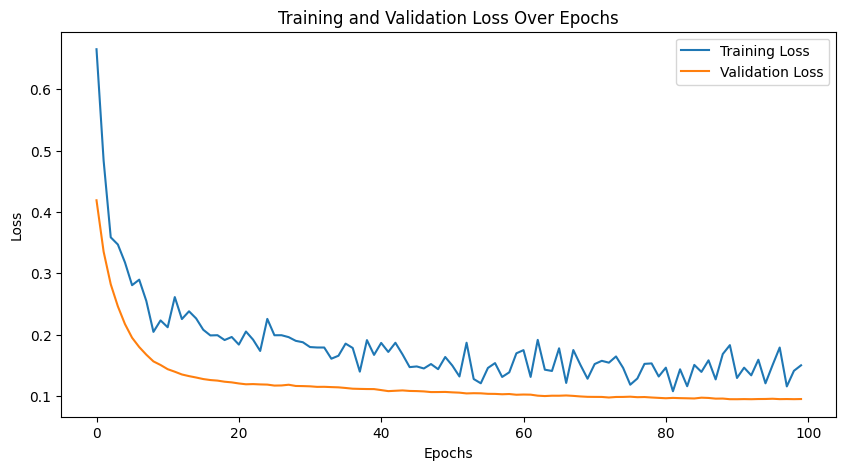

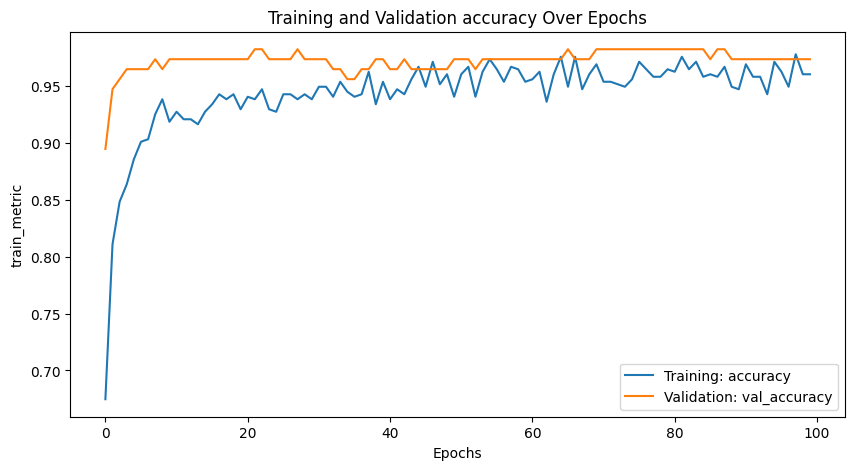

In [20]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()
    
    
plot_training_history(history)

<div style="background-color:#5C7A7A; border-radius: 10px; padding: 10px; margin-bottom: 20px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">Both training and validation loss decrease rapidly in the first few epochs</p>
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">The training loss (blue line) continues to decrease but shows some fluctuations.</p>
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">The validation loss (orange line) decreases more smoothly and plateaus earlier than the training loss.</p>
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">There's a gap between training and validation loss, with training loss being lower, which may indicate some overfitting.</p>
</div>

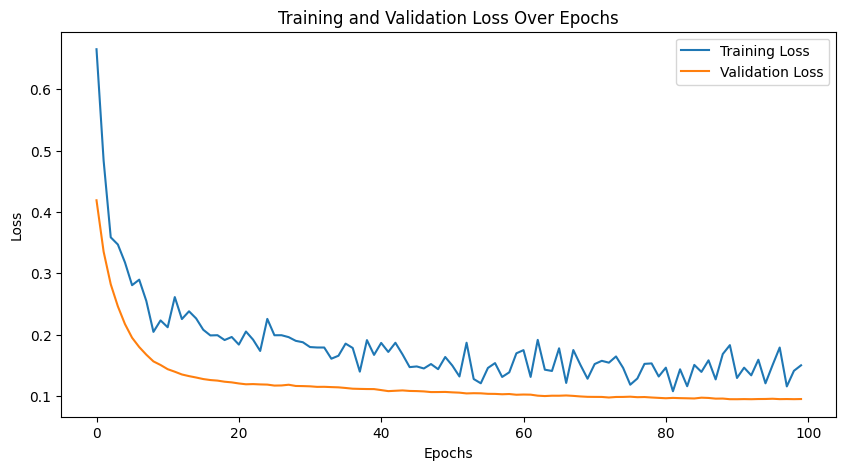

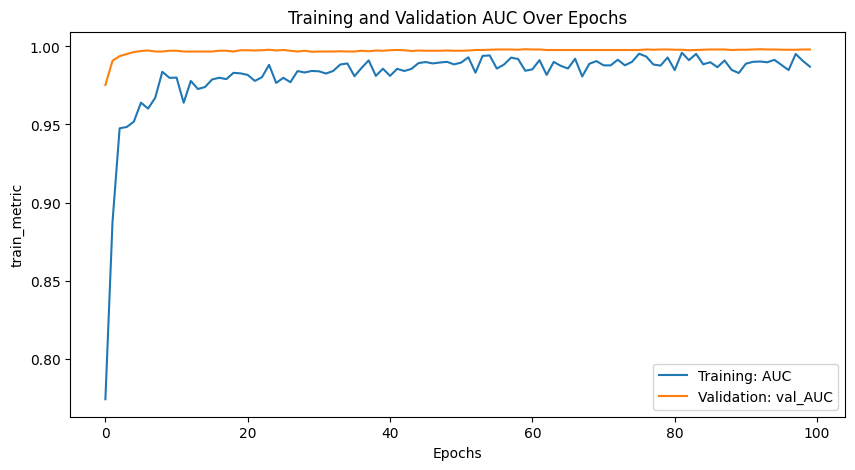

In [21]:
plot_training_history(history, train_metric='AUC', val_metric='val_AUC')

<div style="background-color:#5C7A7A; border-radius: 10px; padding: 10px; margin-bottom: 20px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">Both training and validation AUC increase rapidly in the initial epochs.</p>
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">The validation AUC (orange line) reaches and maintains a slightly higher level than the training AUC (blue line).</p>
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">Both metrics stabilize around 0.95-0.98, indicating good model performance.</p>
    <div style="border-left: 5px solid #F8F8F0; padding-left: 15px;">
        <p style="margin: 10px 0 0 0; font-size: 18px; font-family: Roboto; color: #F8F8F0; text-align: left;">The validation AUC being slightly higher than training AUC is unusual and might warrant further investigation.</p>
</div>

In [22]:
best_model = load_model('/kaggle/working/best_model.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,503 (5.88 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 100 (400.00 B)

 Optimizer params: 2 (12.00 B)

In [23]:
best_model.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': 'float32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 24),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 50,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': {'module': 'keras.regularizers',
     'class_name': 'L2',
     'config': {'l2': 0.001},
     'registered_name': None},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None

In [24]:
def print_model_weights_biases(model, show_values=False):
    for layer in model.layers:
        weights_biases = layer.get_weights()
        if weights_biases:
            print(f"Layer: {layer.name}")
            for i, wb in enumerate(weights_biases):
                if i == 0:
                    type_wb = "Weights"
                else:
                    type_wb = "Biases"
                print(f"  {type_wb} (Count: {wb.size}):")
                print(f"    Min: {np.min(wb):.4f}")
                print(f"    Max: {np.max(wb):.4f}")
                print(f"    Mean: {np.mean(wb):.4f}")
                print(f"    Std Dev: {np.std(wb):.4f}")
                if show_values:
                    print(f"    Values: {wb}")
        else:
            print(f"Layer {layer.name} has no weights or biases.")
            
            
            
print_model_weights_biases(best_model, show_values = False)   

Layer: dense
  Weights (Count: 1200):
    Min: -0.3650
    Max: 0.3376
    Mean: -0.0053
    Std Dev: 0.1559
  Biases (Count: 50):
    Min: -0.0438
    Max: 0.2059
    Mean: 0.0204
    Std Dev: 0.0428
Layer: batch_normalization
  Weights (Count: 50):
    Min: 0.9444
    Max: 1.1039
    Mean: 1.0030
    Std Dev: 0.0318
  Biases (Count: 50):
    Min: -0.0751
    Max: 0.1901
    Mean: 0.0166
    Std Dev: 0.0664
  Biases (Count: 50):
    Min: 0.1285
    Max: 0.7010
    Mean: 0.3389
    Std Dev: 0.1068
  Biases (Count: 50):
    Min: 0.0443
    Max: 1.4034
    Mean: 0.2565
    Std Dev: 0.2222
Layer dropout has no weights or biases.
Layer: dense_1
  Weights (Count: 50):
    Min: -0.4791
    Max: 0.5579
    Mean: 0.0146
    Std Dev: 0.2272
  Biases (Count: 1):
    Min: -0.3694
    Max: -0.3694
    Mean: -0.3694
    Std Dev: 0.0000
